## Library and data import

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import evaluate
import torch
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

random.seed(12345)
color = "#4B1D91CC"

C:\Users\rami0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check for GPU or MPS and set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
elif torch.backend.mps.is_available():
    device = torch.device("mps")
    print(f'There are {torch.mps.device_count()} MPS(s) available.')
    print('Device name:', torch.mps.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU or MPS available, using the CPU instead.')

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 2080 Ti


In [3]:
dataset = load_dataset("PolyAI/banking77")
dataset.set_format(type="torch")

## Text exploration and preprocessing

In [4]:
# extracting the test and train splits
data_train = dataset["train"]
data_test = dataset["test"]

labels = data_train.features["label"].names

labels_df = pd.DataFrame(data_train["label"], columns=["label"])
test_labels_df = pd.DataFrame(data_test["label"], columns=["label"])

label2idx = {label: i for i, label in enumerate(labels)}
idx2label = {i: label for i, label in enumerate(labels)}

In [5]:
# sorting the labels by their frequency for a nicer plot
sorted_labels = labels_df["label"].value_counts().index

sorted_label_names = [labels[i] for i in sorted_labels]

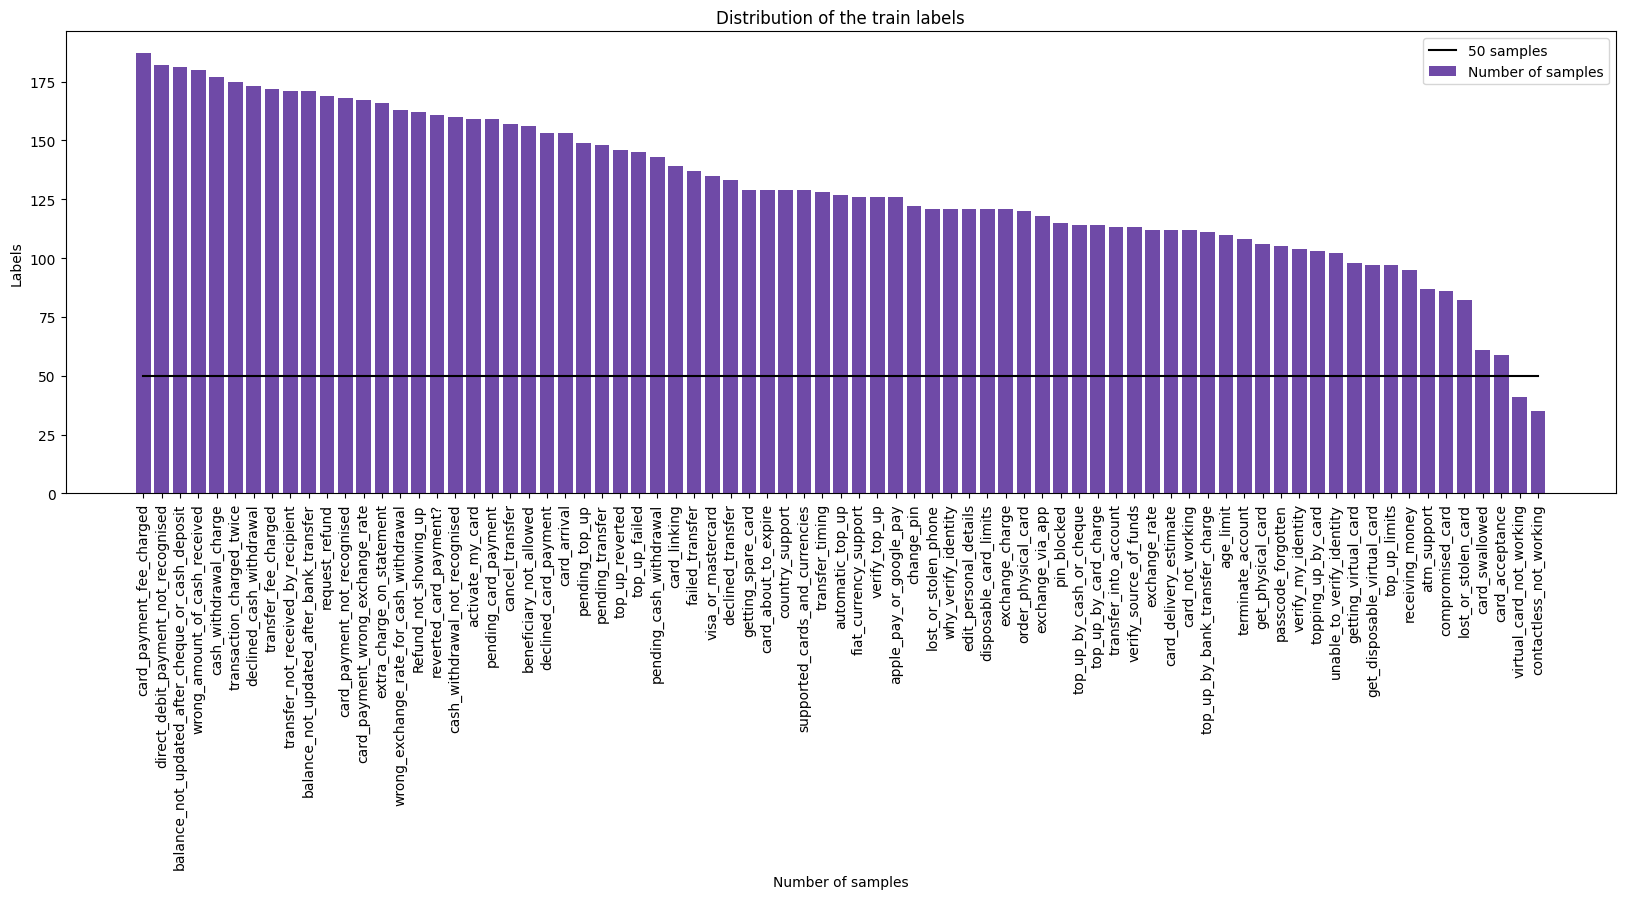

In [6]:
# plotting the distribution of the labels
plt.figure(figsize=(20, 6))
plt.bar(sorted_label_names, labels_df.value_counts(), color=color)
plt.plot(sorted_label_names, [50]*len(sorted_label_names), color="black")
plt.xticks(rotation=90)
plt.legend(["50 samples", "Number of samples"])
plt.title("Distribution of the train labels")
plt.xlabel("Number of samples")
plt.ylabel("Labels")
plt.show()

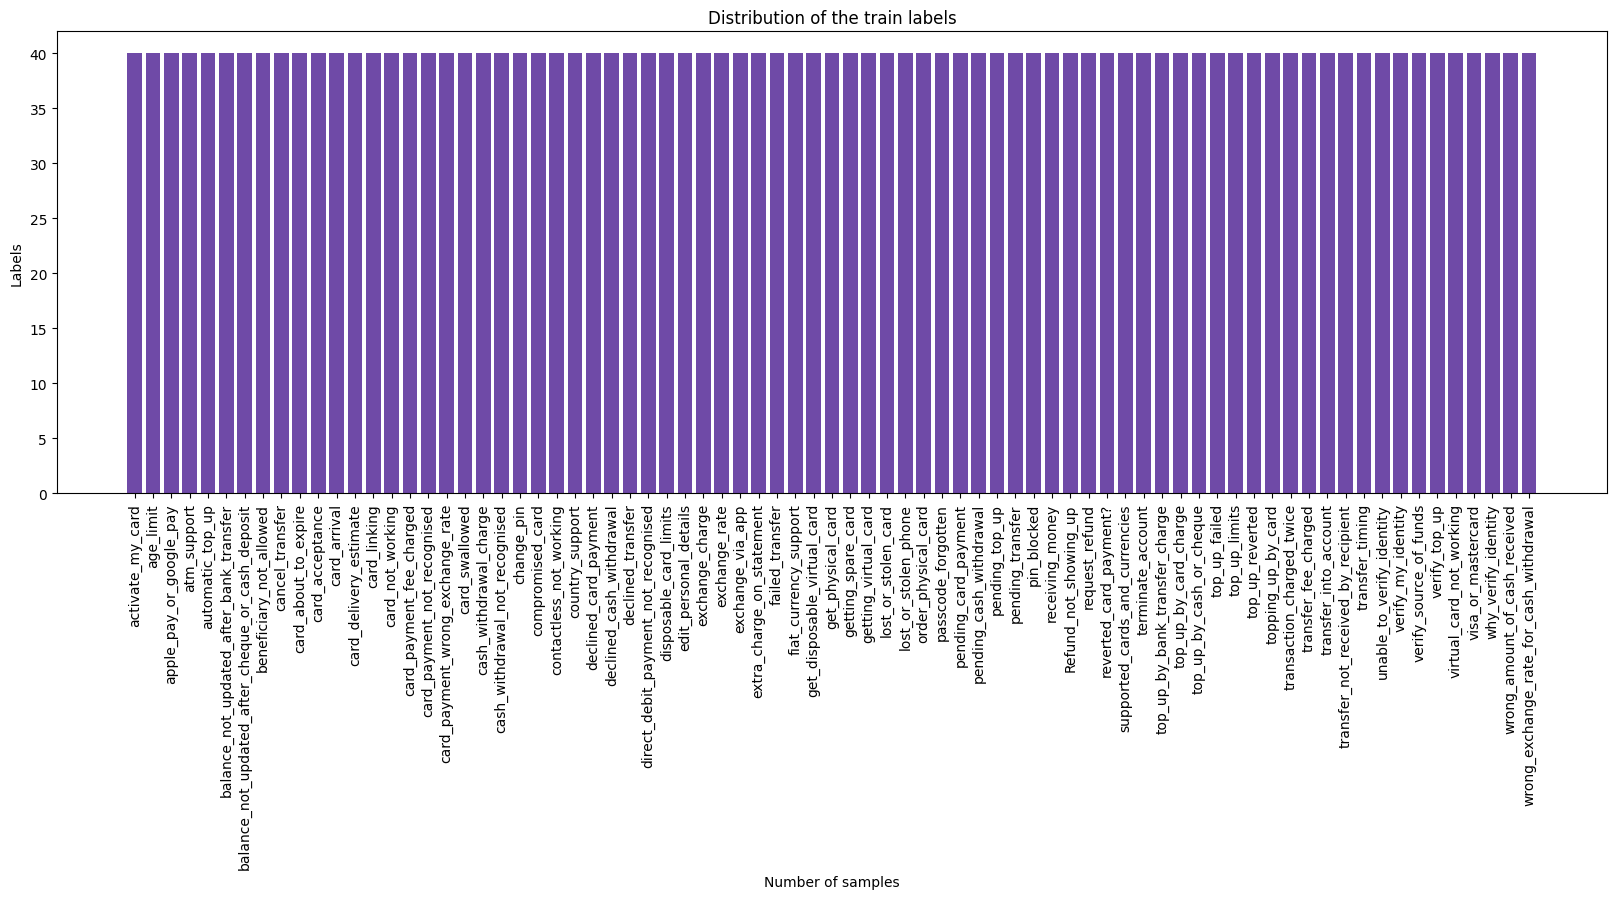

In [7]:
labels_count_test = pd.DataFrame(data_test["label"], columns=["label"])["label"].value_counts()

plt.figure(figsize=(20, 6))
plt.bar(labels, test_labels_df.value_counts(sort=False), color=color)
plt.xticks(rotation=90)
plt.title("Distribution of the train labels")
plt.xlabel("Number of samples")
plt.ylabel("Labels")
plt.show()

In [8]:
# display some random samples from the dataset
data_train.shuffle().select(range(10))["text"]

['need to exchange currencies',
 'I withdrew cash but it still shows as pending?',
 'I wanted $100 but only got $20',
 'It seems that something went wrong with my exchange. I changed Russian Ruble into UK pounds but have been charged entirely too much!',
 'Please explain the charge of 1L in error.  I have purchased nothing in this amount.',
 'I have a payment that has not gone through yet',
 'Does the app allowing exchanges between USD and GBP',
 'the product is not working, can I get a refund?',
 'Do you give refunds?',
 'Can I get the Mastercard?']

### Tokenization:
As I chose to use TF-IDF and DistilBERT, this section is to setup the vectorizer and tokenizer for both models.

In [36]:
tf_vectorizer = TfidfVectorizer(tokenizer=lambda text: text.split(), lowercase=True) # Not removing stop words increases the models performance

dbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_dbert(texts):
    '''
    Function to wrap the DistilBERT tokenizer and restrict the maximum length of the tokenized sequence to DistilBERT's maximum length.
    -----
    Use the Datasets .map() function to apply this function to the entire dataset (For the fastest results use batched=True).
    dataset_to_tokenize.map(preprocess_dbert, batched=True)

    Parameters
    ----------
    texts: str
        The text to be tokenized.

    Returns
    -------
    dict
        The tokenized text.
    '''
    return dbert_tokenizer(texts["text"], truncation=True)

In [37]:
# Vectorize the training data for TF-IDF
tf_train = tf_vectorizer.fit_transform(data_train["text"])
tf_test = tf_vectorizer.transform(data_test["text"])

C:\Users\rami0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [11]:
# Tokenize the dataset for DistilBERT
tokenized_data_dbert = dataset.map(preprocess_dbert, batched=True)

tokenized_data_dbert

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3080
    })
})

In [12]:
from sklearn.metrics import f1_score

# setup the data collator and evaluiation metrics
data_collator = DataCollatorWithPadding(tokenizer=dbert_tokenizer)

accuracy = evaluate.load("accuracy")
f1_score_eval = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1 = f1_score_eval.compute(predictions=predictions, references=labels, average="weighted")
    f1_macro = f1_score(labels, predictions, average="macro")
    f1_micro = f1_score(labels, predictions, average="micro")
    return {"accuracy": acc, "f1": f1, "f1_macro": f1_macro, "f1_micro": f1_micro}

## Training the models
### TF-IDF:
#### Initializing the model

In [13]:
# Initialize the SVM classifier
svm_clf_ovr = LinearSVC(max_iter=100000, dual=False, tol=1e-2)
svm_clf_crammer = LinearSVC(max_iter=100000, dual=False, tol=1e-5, multi_class="crammer_singer")

#### Fitting the model on the data

In [14]:
# Fit the SVM classifier on the vectorized training data
svm_clf_ovr.fit(tf_train, data_train["label"])
svm_clf_crammer.fit(tf_train, data_train["label"])

C:\Users\rami0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual=False, max_iter=100000, multi_class='crammer_singer', tol=1e-05)

In [15]:
# Calculate predicitons on the vectorized test data
y_pred_tf_ovr = svm_clf_ovr.predict(tf_test)
y_pred_tf_crammer = svm_clf_crammer.predict(tf_test)

accuracy_tf_ovr = accuracy.compute(predictions=y_pred_tf_ovr, references=data_test["label"])
f1_tf_ovr = f1_score_eval.compute(predictions=y_pred_tf_ovr, references=data_test["label"], average="weighted")
f1_tf_ovr_macro = f1_score(y_pred=y_pred_tf_ovr, y_true=data_test["label"], average="macro")
f1_tf_ovr_micro = f1_score(y_pred=y_pred_tf_ovr, y_true=data_test["label"], average="micro")

accuracy_tf_crammer = accuracy.compute(predictions=y_pred_tf_crammer, references=data_test["label"])
f1_tf_crammer = f1_score_eval.compute(predictions=y_pred_tf_crammer, references=data_test["label"], average="weighted")
f1_tf_crammer_macro = f1_score(y_pred=y_pred_tf_crammer, y_true=data_test["label"], average="macro")
f1_tf_crammer_micro = f1_score(y_pred=y_pred_tf_crammer, y_true=data_test["label"], average="micro")

print("TF-IDF Accuracy with OVR: ", accuracy_tf_ovr)
print("TF-IDF F1 Score with OVR: ", f1_tf_ovr)
print("TF-IDF F1 Score with OVR (Macro): ", f1_tf_ovr_macro)
print("TF-IDF F1 Score with OVR (Micro): ", f1_tf_ovr_micro)

print("TF-IDF Accuracy with Crammer: ", accuracy_tf_crammer)
print("TF-IDF F1 Score with Crammer: ", f1_tf_crammer)
print("TF-IDF F1 Score with Crammer (Macro): ", f1_tf_crammer_macro)
print("TF-IDF F1 Score with Crammer (Micro): ", f1_tf_crammer_micro)

TF-IDF Accuracy with OVR:  {'accuracy': 0.8821428571428571}
TF-IDF F1 Score with OVR:  {'f1': 0.8816450869137121}
TF-IDF F1 Score with OVR (Macro):  0.8816450869137119
TF-IDF F1 Score with OVR (Micro):  0.8821428571428571
TF-IDF Accuracy with Crammer:  {'accuracy': 0.8857142857142857}
TF-IDF F1 Score with Crammer:  {'f1': 0.8856343362093156}
TF-IDF F1 Score with Crammer (Macro):  0.8856343362093152
TF-IDF F1 Score with Crammer (Micro):  0.8857142857142857


Having tested multiple different hyperparameter setups (I didnt bother grid searching as there were so little hyperparameters to test anyway so I just used my intuition), I found that the only 2 hyperparameters that gave me truly better results were changing the multi-class strategy from "ovr" to "crammer_singer" and including stop-words in the vectorizer, most other hyperparameter changes just gave me marginally better or worse results in the 1/10th or less of a percent range.

#### Hyperparameter tuning and n-gram length testing:
To implement a grid search on different n-gram lengths I redefine the vectorizer and create a pipeline to run the grid search on.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score

tf_vectorizer_gs = TfidfVectorizer(tokenizer=lambda text: text.split(), lowercase=True)
svm_clf = LinearSVC(max_iter=100000, dual=False, tol=1e-5, multi_class="crammer_singer")

tf_pipeline = Pipeline([
    ("tfidf", tf_vectorizer_gs),
    ("svm", svm_clf)
])

param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__stop_words': [None, 'english'],
}

scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f1_weighted': make_scorer(f1_score, average="weighted"),
    'f1_macro': make_scorer(f1_score, average="macro"),
    'f1_micro': make_scorer(f1_score, average="micro")
}

grid_search = GridSearchCV(tf_pipeline, param_grid, scoring=scorers, refit="f1_macro", cv=5, n_jobs=-1, verbose=1)

grid_search.fit(data_train["text"], data_train["label"])

In [20]:
print("The best parameter set found on the training set:")
print(grid_search.best_params_)

print("The best score found on the training set: ", grid_search.best_score_)

results = pd.DataFrame(grid_search.cv_results_)
results

The best parameter set found on the training set:
{'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}
The best score found on the training set:  0.8621851848334575


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf__ngram_range,param_tfidf__stop_words,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_micro,split1_test_f1_micro,split2_test_f1_micro,split3_test_f1_micro,split4_test_f1_micro,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro
0,9.317213,1.572488,0.034901,0.003957,"(1, 1)",None,"{'tfidf__ngram_range': (1, 1), 'tfidf__stop_wo...",0.862569,0.859070,0.869065,...,0.006000,1,0.862569,0.859070,0.869065,0.8705,0.8570,0.863641,0.005341,1
1,13.789157,8.139204,0.032504,0.004774,"(1, 1)",english,"{'tfidf__ngram_range': (1, 1), 'tfidf__stop_wo...",0.823588,0.821089,0.818591,...,0.001964,4,0.823588,0.821089,0.818591,0.8235,0.8205,0.821454,0.001896,4
2,17.101088,3.834270,0.086920,0.020524,"(1, 2)",None,"{'tfidf__ngram_range': (1, 2), 'tfidf__stop_wo...",0.853573,0.856072,0.855072,...,0.006215,2,0.853573,0.856072,0.855072,0.8690,0.8630,0.859344,0.005811,2
3,27.787594,5.957686,0.048812,0.023746,"(1, 2)",english,"{'tfidf__ngram_range': (1, 2), 'tfidf__stop_wo...",0.812594,0.806097,0.813593,...,0.004609,5,0.812594,0.806097,0.813593,0.8190,0.8100,0.812257,0.004252,5
4,50.609915,50.992385,0.090818,0.030819,"(1, 3)",None,"{'tfidf__ngram_range': (1, 3), 'tfidf__stop_wo...",0.836582,0.846577,0.838581,...,0.007139,3,0.836582,0.846577,0.838581,0.8525,0.8460,0.844048,0.005784,3
5,33.108616,8.453301,0.033203,0.008067,"(1, 3)",english,"{'tfidf__ngram_range': (1, 3), 'tfidf__stop_wo...",0.810595,0.801599,0.805597,...,0.002511,6,0.810595,0.801599,0.805597,0.8095,0.8075,0.806958,0.003180,6


After doing a grid search including ngram lengths and comparing the use of stop words, I feel my intuition earlier on parameters was correct. Although one surprise was that the "default" parameters when included in a grid search, yeilded worse results for all the metrics compared to the non gridsearched model with the exact same parameters. 

In conclusion, the longer the n-gram range becomes, the worse the results. I feel this makes sense as the inquiries/data in the dataset are so short not being more than a sentence or two. Additionally, excluding stop words also yeilded worse results, again which makes sense to me as in an inquiry/question case like this, stop words are important to the context and meaning of the sentence.

### DistilBERT:

In [22]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig
from torchinfo import summary

# setup the config for the model
num_labels = dataset["train"].features["label"].num_classes

config = AutoConfig.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

In [23]:
# adjust the config to match number and name of labels in the dataset
config.id2label = idx2label.copy()
config.label2id = label2idx.copy()

config.id2label

{0: 'activate_my_card',
 1: 'age_limit',
 2: 'apple_pay_or_google_pay',
 3: 'atm_support',
 4: 'automatic_top_up',
 5: 'balance_not_updated_after_bank_transfer',
 6: 'balance_not_updated_after_cheque_or_cash_deposit',
 7: 'beneficiary_not_allowed',
 8: 'cancel_transfer',
 9: 'card_about_to_expire',
 10: 'card_acceptance',
 11: 'card_arrival',
 12: 'card_delivery_estimate',
 13: 'card_linking',
 14: 'card_not_working',
 15: 'card_payment_fee_charged',
 16: 'card_payment_not_recognised',
 17: 'card_payment_wrong_exchange_rate',
 18: 'card_swallowed',
 19: 'cash_withdrawal_charge',
 20: 'cash_withdrawal_not_recognised',
 21: 'change_pin',
 22: 'compromised_card',
 23: 'contactless_not_working',
 24: 'country_support',
 25: 'declined_card_payment',
 26: 'declined_cash_withdrawal',
 27: 'declined_transfer',
 28: 'direct_debit_payment_not_recognised',
 29: 'disposable_card_limits',
 30: 'edit_personal_details',
 31: 'exchange_charge',
 32: 'exchange_rate',
 33: 'exchange_via_app',
 34: 'extr

#### Setting up the model

In [24]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

non_distil_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['transformer.layer.4.attention.k_lin.weight', 'transformer.layer.0.ffn.lin2.weight', 'transformer.layer.5.sa_layer_norm.bias', 'transformer.layer.2.ffn.lin2.weight', 'transformer.layer.4.attention.out_lin.bias', 'transformer.layer.4.attention.v_lin.bias', 'transformer.layer.2.attention.k_lin.bias', 'transformer.layer.3.sa_layer_norm.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.3.attention.k_lin.bias', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.2.ff

In [25]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           59,213
├─Dropout: 1-4                                          --
Total params: 67,012,685
Trainable params: 67,012,685
Non-trainable params: 0

#### Defining training arugments and trainer

In [26]:
# setting up the training arguments and trainer
output_dir = "./Models/distilbert_base_uncased"
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    learning_rate=1e-4,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data_dbert["train"],
    eval_dataset=tokenized_data_dbert["test"],
    data_collator=data_collator,
    tokenizer=dbert_tokenizer,
    compute_metrics=compute_metrics
)

#### Non distiled BERT for curiosity:

In [27]:
output_dir = "./Models/bert_base_uncased"
training_args_bert = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    learning_rate=1e-4,
)

trainer_bert = Trainer(
    model=model,
    args=training_args_bert,
    train_dataset=tokenized_data_dbert["train"],
    eval_dataset=tokenized_data_dbert["test"],
    data_collator=data_collator,
    tokenizer=dbert_tokenizer,
    compute_metrics=compute_metrics
)

#### Training the model

In [28]:
trainer.train()

  0%|          | 0/1565 [00:00<?, ?it/s]You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
                                                  
 20%|██        | 313/1565 [00:42<02:17,  9.13it/s]

{'eval_loss': 0.5594950318336487, 'eval_accuracy': {'accuracy': 0.8584415584415584}, 'eval_f1': {'f1': 0.8495892822843605}, 'eval_f1_macro': 0.8495892822843605, 'eval_f1_micro': 0.8584415584415584, 'eval_runtime': 2.7906, 'eval_samples_per_second': 1103.694, 'eval_steps_per_second': 17.559, 'epoch': 1.0}


 32%|███▏      | 502/1565 [01:06<01:51,  9.50it/s]

{'loss': 1.307, 'learning_rate': 6.805111821086262e-05, 'epoch': 1.6}


                                                  
 40%|████      | 626/1565 [01:24<01:45,  8.87it/s]

{'eval_loss': 0.33440202474594116, 'eval_accuracy': {'accuracy': 0.9116883116883117}, 'eval_f1': {'f1': 0.9120481581706692}, 'eval_f1_macro': 0.9120481581706691, 'eval_f1_micro': 0.9116883116883117, 'eval_runtime': 2.9354, 'eval_samples_per_second': 1049.261, 'eval_steps_per_second': 16.693, 'epoch': 2.0}


                                                  
 60%|██████    | 939/1565 [02:05<01:06,  9.36it/s]

{'eval_loss': 0.28942975401878357, 'eval_accuracy': {'accuracy': 0.9243506493506494}, 'eval_f1': {'f1': 0.9244180020715221}, 'eval_f1_macro': 0.9244180020715219, 'eval_f1_micro': 0.9243506493506494, 'eval_runtime': 2.9749, 'eval_samples_per_second': 1035.317, 'eval_steps_per_second': 16.471, 'epoch': 3.0}


 64%|██████▍   | 1001/1565 [02:15<01:19,  7.08it/s]

{'loss': 0.1762, 'learning_rate': 3.610223642172524e-05, 'epoch': 3.19}


                                                   
 80%|████████  | 1252/1565 [02:49<00:36,  8.51it/s]

{'eval_loss': 0.28331518173217773, 'eval_accuracy': {'accuracy': 0.9305194805194805}, 'eval_f1': {'f1': 0.9304095827271768}, 'eval_f1_macro': 0.930409582727177, 'eval_f1_micro': 0.9305194805194805, 'eval_runtime': 3.0559, 'eval_samples_per_second': 1007.896, 'eval_steps_per_second': 16.035, 'epoch': 4.0}


 96%|█████████▌| 1501/1565 [03:21<00:06,  9.63it/s]

{'loss': 0.0516, 'learning_rate': 4.153354632587859e-06, 'epoch': 4.79}


                                                   
100%|██████████| 1565/1565 [03:33<00:00,  7.62it/s]

{'eval_loss': 0.27498775720596313, 'eval_accuracy': {'accuracy': 0.9347402597402598}, 'eval_f1': {'f1': 0.934673454742274}, 'eval_f1_macro': 0.934673454742274, 'eval_f1_micro': 0.9347402597402598, 'eval_runtime': 3.2189, 'eval_samples_per_second': 956.84, 'eval_steps_per_second': 15.222, 'epoch': 5.0}


100%|██████████| 1565/1565 [03:34<00:00,  7.30it/s]

{'train_runtime': 214.5309, 'train_samples_per_second': 233.137, 'train_steps_per_second': 7.295, 'train_loss': 0.49132841044721515, 'epoch': 5.0}


TrainOutput(global_step=1565, training_loss=0.49132841044721515, metrics={'train_runtime': 214.5309, 'train_samples_per_second': 233.137, 'train_steps_per_second': 7.295, 'train_loss': 0.49132841044721515, 'epoch': 5.0})

In [29]:
trainer_bert.train()

 20%|██        | 313/1565 [00:40<02:29,  8.40it/s]

{'eval_loss': 0.4016958773136139, 'eval_accuracy': {'accuracy': 0.910064935064935}, 'eval_f1': {'f1': 0.9099178948730132}, 'eval_f1_macro': 0.9099178948730131, 'eval_f1_micro': 0.910064935064935, 'eval_runtime': 3.0009, 'eval_samples_per_second': 1026.348, 'eval_steps_per_second': 16.328, 'epoch': 1.0}


 32%|███▏      | 501/1565 [01:05<01:57,  9.06it/s]

{'loss': 0.0839, 'learning_rate': 6.805111821086262e-05, 'epoch': 1.6}


 40%|████      | 626/1565 [01:24<01:41,  9.24it/s]

{'eval_loss': 0.3756013810634613, 'eval_accuracy': {'accuracy': 0.923051948051948}, 'eval_f1': {'f1': 0.9228317252486437}, 'eval_f1_macro': 0.9228317252486439, 'eval_f1_micro': 0.923051948051948, 'eval_runtime': 3.0449, 'eval_samples_per_second': 1011.534, 'eval_steps_per_second': 16.093, 'epoch': 2.0}


 60%|██████    | 939/1565 [02:07<01:16,  8.19it/s]

{'eval_loss': 0.39424771070480347, 'eval_accuracy': {'accuracy': 0.9217532467532468}, 'eval_f1': {'f1': 0.9215410940404721}, 'eval_f1_macro': 0.9215410940404725, 'eval_f1_micro': 0.9217532467532468, 'eval_runtime': 2.9519, 'eval_samples_per_second': 1043.403, 'eval_steps_per_second': 16.6, 'epoch': 3.0}


 64%|██████▍   | 1001/1565 [02:17<01:30,  6.23it/s]

{'loss': 0.0382, 'learning_rate': 3.610223642172524e-05, 'epoch': 3.19}


 80%|████████  | 1252/1565 [02:51<00:39,  7.97it/s]

{'eval_loss': 0.3921973407268524, 'eval_accuracy': {'accuracy': 0.9224025974025974}, 'eval_f1': {'f1': 0.9224608930249076}, 'eval_f1_macro': 0.9224608930249079, 'eval_f1_micro': 0.9224025974025974, 'eval_runtime': 3.0089, 'eval_samples_per_second': 1023.618, 'eval_steps_per_second': 16.285, 'epoch': 4.0}


 96%|█████████▌| 1501/1565 [03:23<00:08,  7.85it/s]

{'loss': 0.0064, 'learning_rate': 4.153354632587859e-06, 'epoch': 4.79}


100%|██████████| 1565/1565 [03:36<00:00,  6.05it/s]

{'eval_loss': 0.3936883211135864, 'eval_accuracy': {'accuracy': 0.9243506493506494}, 'eval_f1': {'f1': 0.9244645146398242}, 'eval_f1_macro': 0.9244645146398244, 'eval_f1_micro': 0.9243506493506494, 'eval_runtime': 3.2149, 'eval_samples_per_second': 958.027, 'eval_steps_per_second': 15.241, 'epoch': 5.0}


100%|██████████| 1565/1565 [03:36<00:00,  7.21it/s]

{'train_runtime': 216.979, 'train_samples_per_second': 230.506, 'train_steps_per_second': 7.213, 'train_loss': 0.04136344542899452, 'epoch': 5.0}


TrainOutput(global_step=1565, training_loss=0.04136344542899452, metrics={'train_runtime': 216.979, 'train_samples_per_second': 230.506, 'train_steps_per_second': 7.213, 'train_loss': 0.04136344542899452, 'epoch': 5.0})

In [30]:
trainer.create_model_card() # Creates a model card to quickly share the model's information

In [31]:
trainer_bert.create_model_card()

## Evaluating the models

In [32]:
from transformers import pipeline

In [33]:
# Get some random data from the dataset
random_eval_data = data_test.shuffle().select(range(100))
y_true = random_eval_data["label"]

In [34]:
for i in range(10):
    print(f"Question: {random_eval_data[i]['text']}")
    print(f"True label: {labels[random_eval_data[i]['label']]}")
    print("____________________________________________________")

Question: Are there restrictions for my disposable card since it does not seem to be working?
True label: virtual_card_not_working
____________________________________________________
Question: I'm trying to transfer money to another country. It's just pending and not sending. My account details are correct. Please help me.
True label: pending_transfer
____________________________________________________
Question: What do I do if I notice a strange withdrawl in my statement?
True label: cash_withdrawal_not_recognised
____________________________________________________
Question: I got a message that I need to verify my identity; what do I do?
True label: verify_my_identity
____________________________________________________
Question: How do I use the app if I don't have my phone with me?
True label: lost_or_stolen_phone
____________________________________________________
Question: why is the exchange rate for a Foreign ATM different
True label: wrong_exchange_rate_for_cash_withdrawal

### TF-IDF:

In [38]:
random_eval_data_tf = tf_vectorizer.transform(random_eval_data["text"])

In [39]:
# Calculate predicitons on the randomly selected data
y_pred_tf_eval = svm_clf_crammer.predict(random_eval_data_tf)

print(y_pred_tf_eval[:10])
print(y_true[:10])

[29 48 20 69 42 76 18 31 66  1]
tensor([72, 48, 20, 69, 42, 76, 18, 31, 66,  1])


In [40]:
tf_idf_accuracy_eval = accuracy.compute(predictions=y_pred_tf_eval, references=y_true)
tf_idf_f1_eval = f1_score_eval.compute(predictions=y_pred_tf_eval, references=y_true, average="weighted")
tf_f1_macro_eval = f1_score(y_true, y_pred_tf_eval, average="macro")
tf_f1_micro_eval = f1_score(y_true, y_pred_tf_eval, average="micro")

print("TF-IDF Accuracy: ", tf_idf_accuracy_eval)
print("TF-IDF F1 Score: ", tf_idf_f1_eval)
print("TF-IDF F1 Macro Score: ", tf_f1_macro_eval)
print("TF-IDF F1 Micro Score: ", tf_f1_micro_eval)

print("TF-IDF Accuracy of full test set: ", accuracy_tf_crammer)
print("TF-IDF F1 Score of full test set: ", f1_tf_crammer)
print("TF-IDF F1 Macro Score of full test set: ", f1_tf_crammer_macro)
print("TF-IDF F1 Micro Score of full test set: ", f1_tf_crammer_micro)

TF-IDF Accuracy:  {'accuracy': 0.91}
TF-IDF F1 Score:  {'f1': 0.9231587301587303}
TF-IDF F1 Macro Score:  0.865702947845805
TF-IDF F1 Micro Score:  0.91
TF-IDF Accuracy of full test set:  {'accuracy': 0.8857142857142857}
TF-IDF F1 Score of full test set:  {'f1': 0.8856343362093156}
TF-IDF F1 Macro Score of full test set:  0.8856343362093152
TF-IDF F1 Micro Score of full test set:  0.8857142857142857


Clearly using a random subset of data to evaluate a TF-IDF model doesnt work too well, Im guessing this is because the sparse matrix created by the vectoriser doesnt contain all the classes/words that are in the test/train set therefore the vector space it creates is very different and cant be compared/used in the orgignal model. I would have to find the indecies of the randomlu selected text and then use those indecies to select the same indecies in the vector space created by the vectoriser to get a proper evaluation. But since I already performed a quick evaluation after training I feel thats a decent representation of the accuracy of the model.

### DistilBERT:

In [42]:
trained_model_dbert = AutoModelForSequenceClassification.from_pretrained(output_dir + '/checkpoint-1565', config=config)

dbert_pipe = pipeline("text-classification", model=trained_model_dbert, tokenizer=dbert_tokenizer, device=device)

In [43]:
trainer.model = trained_model_dbert

trainer.evaluate()

100%|██████████| 49/49 [00:03<00:00, 15.99it/s]


{'eval_loss': 0.3936883211135864,
 'eval_accuracy': {'accuracy': 0.9243506493506494},
 'eval_f1': {'f1': 0.9244645146398242},
 'eval_f1_macro': 0.9244645146398244,
 'eval_f1_micro': 0.9243506493506494,
 'eval_runtime': 3.1372,
 'eval_samples_per_second': 981.767,
 'eval_steps_per_second': 15.619,
 'epoch': 5.0}

In [44]:
preds = dbert_pipe(random_eval_data["text"])
preds[:5]

[{'label': 'disposable_card_limits', 'score': 0.999479353427887},
 {'label': 'pending_transfer', 'score': 0.9997217059135437},
 {'label': 'cash_withdrawal_not_recognised', 'score': 0.9997848868370056},
 {'label': 'verify_my_identity', 'score': 0.9995453953742981},
 {'label': 'lost_or_stolen_phone', 'score': 0.9997902512550354}]

In [45]:
y_pred = [label2idx[pred["label"]] for pred in preds]
print(y_pred[:5])
print(y_true[:5])

[29, 48, 20, 69, 42]
tensor([72, 48, 20, 69, 42])


#### Calculate the metrics on the randomly selected eval data

In [47]:
print(f"Accuracy: {accuracy.compute(predictions=y_pred, references=y_true)}")
print(f"F1 score: {f1_score_eval.compute(predictions=y_pred, references=y_true, average='weighted')}")

Accuracy: {'accuracy': 0.91}
F1 score: {'f1': 0.9121212121212122}


In [48]:
preds = dbert_pipe(data_test["text"])
preds_tf = svm_clf_crammer.predict(tf_test)

In [49]:
# Get the false predictions of both models on all test data
false_preds_tf = []
false_preds_dbert = []

for i in range(len(preds)):
    if label2idx[preds[i]["label"]] != data_test["label"][i]:
        false_preds_dbert.append((data_test["text"][i], labels[data_test["label"][i]], preds[i]["label"]))
    if preds_tf[i] != data_test["label"][i]:
        false_preds_tf.append((data_test["text"][i], labels[data_test["label"][i]], idx2label[y_pred_tf_crammer[i]]))

print(len(false_preds_tf))
print(len(false_preds_dbert))

false_pred_count_tf = {}
false_pred_count_dbert = {}

for pred in false_preds_tf:
    if pred[1] in false_pred_count_tf:
        false_pred_count_tf[pred[1]] += 1
    else:
        false_pred_count_tf[pred[1]] = 1

for pred in false_preds_dbert:
    if pred[1] in false_pred_count_dbert:
        false_pred_count_dbert[pred[1]] += 1
    else:
        false_pred_count_dbert[pred[1]] = 1

sorted_labels_tf = sorted(false_pred_count_tf, key=false_pred_count_tf.get, reverse=True)
sorted_labels_dbert = sorted(false_pred_count_dbert, key=false_pred_count_dbert.get, reverse=True)

352
233


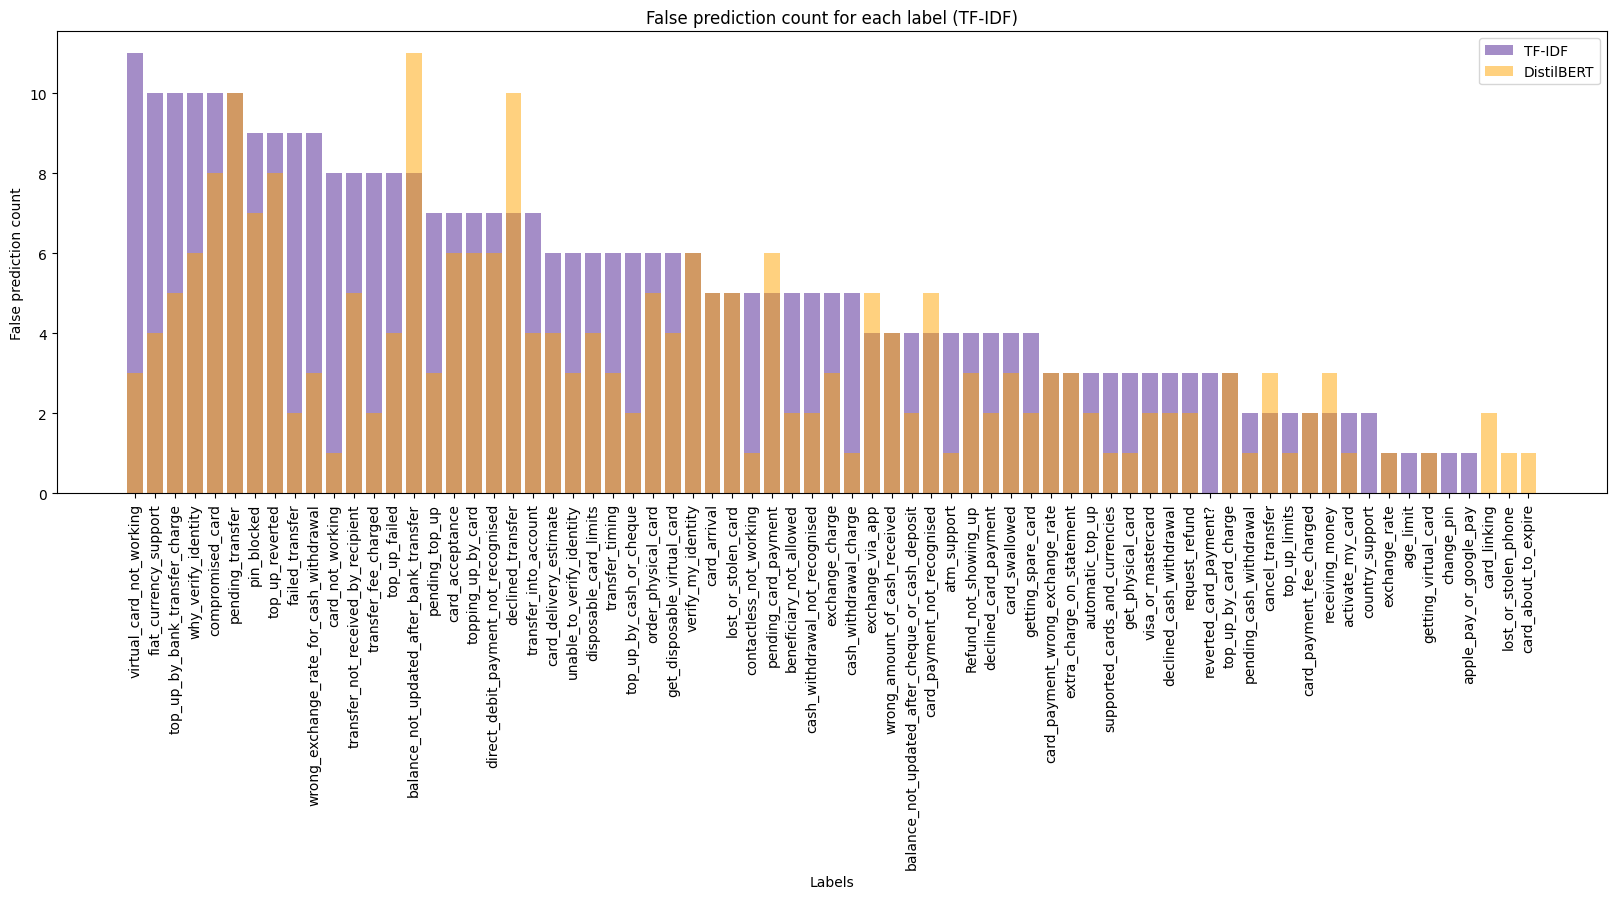

In [50]:
plt.figure(figsize=(20, 6))
plt.bar(sorted_labels_tf, [false_pred_count_tf[label] for label in sorted_labels_tf], color=color, label="TF-IDF", alpha=0.5)
plt.bar(sorted_labels_dbert, [false_pred_count_dbert[label] for label in sorted_labels_dbert], color="#FFA500CC", label="DistilBERT", alpha=0.5)
plt.xticks(rotation=90)
plt.title("False prediction count for each label (TF-IDF)")
plt.xlabel("Labels")
plt.ylabel("False prediction count")
plt.legend()
plt.show()

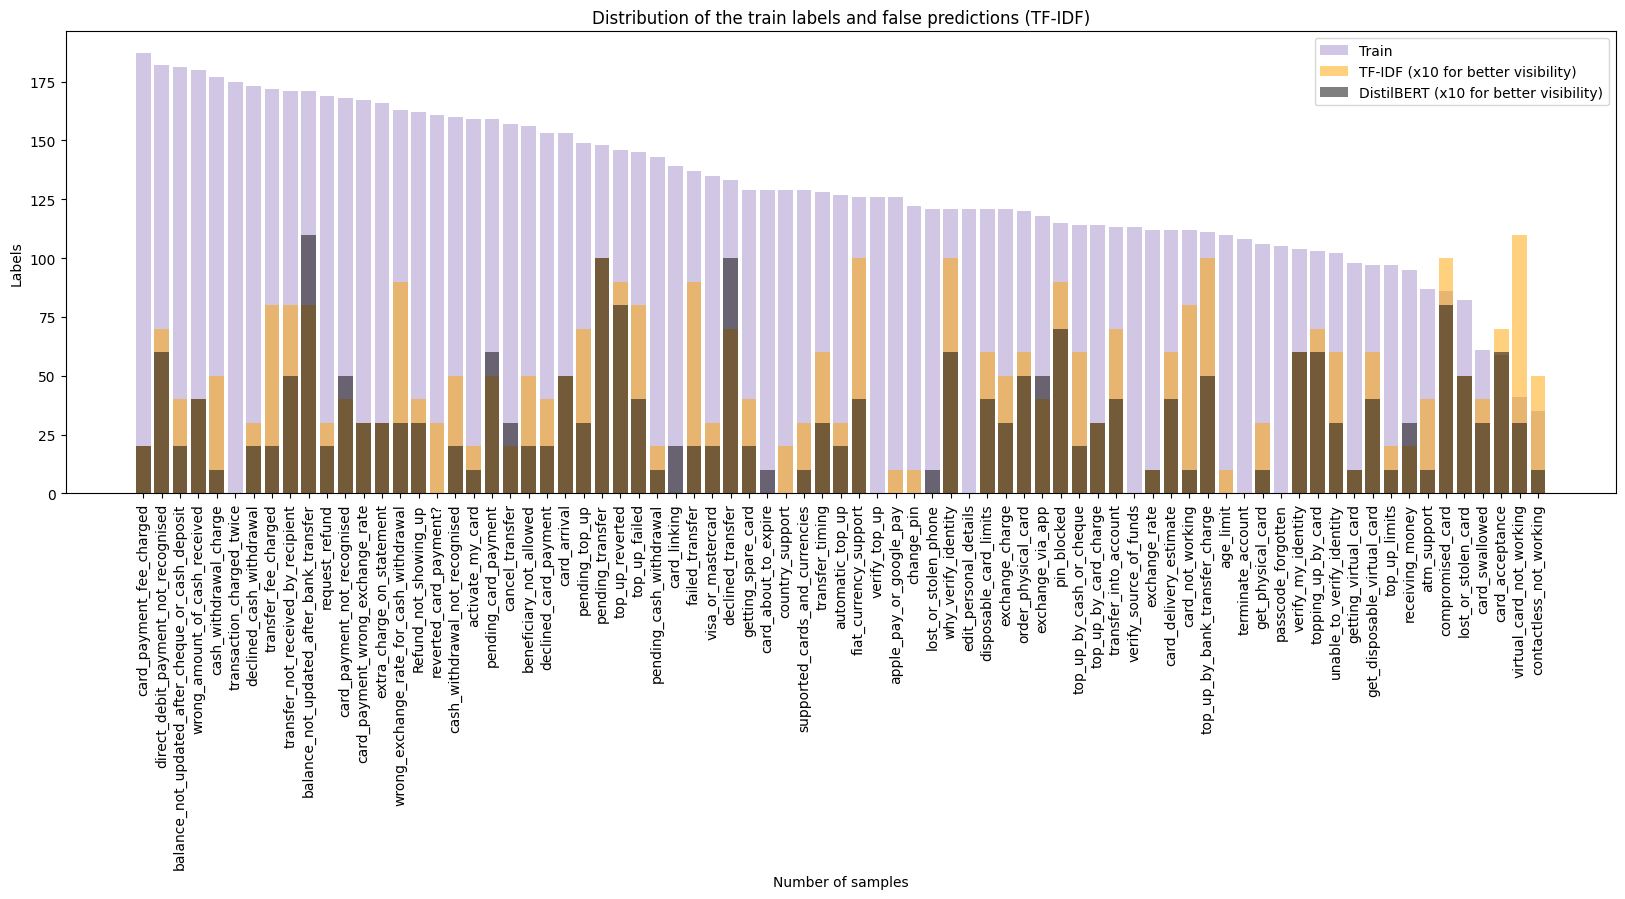

In [60]:
plt.figure(figsize=(20, 6))
plt.bar(sorted_label_names, labels_df.value_counts(), color=color, alpha=0.25, label="Train")
plt.bar(sorted_labels_tf, [false_pred_count_tf[label]*10 for label in sorted_labels_tf], color="#FFA500CC", alpha=0.5, label="TF-IDF (x10 for better visibility)")
plt.bar(sorted_labels_dbert, [false_pred_count_dbert[label]*10 for label in sorted_labels_dbert], color="black", alpha=0.5, label="DistilBERT (x10 for better visibility)")
plt.xticks(rotation=90)
plt.legend()
plt.title("Distribution of the train labels and false predictions (TF-IDF)")
plt.xlabel("Number of samples")
plt.ylabel("Labels")
plt.show()

In [61]:
import pprint

In [66]:
print("TF-IDF:")
for label in sorted_labels_tf[:15]:
    print(label, false_pred_count_tf[label])

TF-IDF:
virtual_card_not_working 11
fiat_currency_support 10
top_up_by_bank_transfer_charge 10
why_verify_identity 10
compromised_card 10
pending_transfer 10
pin_blocked 9
top_up_reverted 9
failed_transfer 9
wrong_exchange_rate_for_cash_withdrawal 9
card_not_working 8
transfer_not_received_by_recipient 8
transfer_fee_charged 8
top_up_failed 8
balance_not_updated_after_bank_transfer 8


In [67]:
print("DistilBERT:")
for label in sorted_labels_dbert[:15]:
    print(label, false_pred_count_dbert[label])

DistilBERT:
balance_not_updated_after_bank_transfer 11
declined_transfer 10
pending_transfer 10
top_up_reverted 8
compromised_card 8
pin_blocked 7
card_acceptance 6
why_verify_identity 6
topping_up_by_card 6
direct_debit_payment_not_recognised 6
pending_card_payment 6
verify_my_identity 6
card_arrival 5
exchange_via_app 5
lost_or_stolen_card 5


In [68]:
average_false_tf = sum(false_pred_count_tf.values())/len(false_pred_count_tf)
average_false_dbert = sum(false_pred_count_dbert.values())/len(false_pred_count_dbert)

print("Average false predictions per label (TF-IDF): ", average_false_tf)
print("Average false predictions per label (DistilBERT): ", average_false_dbert)

Average false predictions per label (TF-IDF):  5.176470588235294
Average false predictions per label (DistilBERT):  3.5303030303030303


In [69]:
# Compare top 15 false labels and show which labels are in both lists
print("Labels in both lists:")
for label in sorted_labels_tf[:15]:
    if label in sorted_labels_dbert[:15]:
        print(label)

Labels in both lists:
why_verify_identity
compromised_card
pending_transfer
pin_blocked
top_up_reverted
balance_not_updated_after_bank_transfer


When comparing the frequency of false labels, there does seem to be a very small correlation towards the original distribution of the training set. Although this correlation seems to be stronger with the TF-IDF model but still on the weaker side, this indicates to me that BERT models are slightly more robust and less prone to overfitting.

Furthermore, when looking at the top 15 falsely predicted labels, both of the models top out at 11 false predictions for their top label, but distilberts average is much lower at around 3.5 false predictions per label compared to TF-IDF's 5. 

And lastly, there arent many labels that overlap the two models top 15 false predictions, only 6/15 overlap. And I myself cant see any obvious language patterns in the labels of both models that would lead to one being worse at a certain context than the other, but that could be because of the short nature of the inquiries or my own knowhow of language quirks and NLP.

## Conclusion
Both models seem to perform decently well, although not close to perfect they both showed performance in the >85% range which I think can be considered acceptable. TF-IDF with a linear SVM classifier seems to offer speed and simplicity while distilBERT offers more robustness and performance at the cost of computation and inference speed.